# Project # 17  Conversation, Capture and Notes, generations during GP clinic visit
At the current stage, we have completed the audio denoising, differentiation of patient and doctor voices, and generation of conversation text, primarily utilizing the Pyannote and Whisper libraries. Specific environmental requirements can be referred to in the requirements.txt file.

# Setup the Environment

In [1]:
!nvidia-smi

Tue Nov 28 06:57:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from IPython.display import HTML, clear_output
!rm -rf /content/sample_data
!mkdir /content/sample_data

!git clone https://github.com/justinjohn0306/Wav2Lip

%cd /content/Wav2Lip

#download the pretrained model
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/wav2lip.pth' -O 'checkpoints/wav2lip.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/wav2lip_gan.pth' -O 'checkpoints/wav2lip_gan.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/resnet50.pth' -O 'checkpoints/resnet50.pth'
!wget 'https://github.com/justinjohn0306/Wav2Lip/releases/download/models/mobilenet.pth' -O 'checkpoints/mobilenet.pth'
a = !pip install https://raw.githubusercontent.com/AwaleSajil/ghc/master/ghc-1.0-py3-none-any.whl
!pip install git+https://github.com/elliottzheng/batch-face.git@master

!pip install ffmpeg-python mediapipe==0.8.11

# for elevenlabs
!pip install git+https://github.com/elevenlabs/elevenlabs-python.git

# for moviepy
!pip install moviepy
!pip install pydub SpeechRecognition
!apt install ffmpeg
!pip install gtts

# for subtitle generator
!pip install git+https://github.com/m1guelpf/auto-subtitle.git

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

%cd /
from ghc.l_ghc_cf import l_ghc_cf
%cd content

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr


from IPython.display import HTML
from base64 import b64encode
def showVideo(path):
  mp4 = open(str(path),'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=700 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

from IPython.display import clear_output

clear_output()
print("All set and ready!")

All set and ready!


In [3]:
import os
import shutil
from google.colab import drive
from google.colab import files
from IPython.display import HTML, clear_output
from base64 import b64encode
import moviepy.editor as mp
import cv2
from IPython.display import Audio
from IPython.core.display import display
from google.colab import files
import librosa
import soundfile as s
from IPython.display import Audio
from IPython.core.display import display
from elevenlabs import set_api_key
from elevenlabs import save, generate, play
import uuid
import requests
from datetime import datetime, timedelta
from moviepy.editor import VideoFileClip, concatenate_videoclips
from pydub import AudioSegment
from pydub.silence import split_on_silence
import speech_recognition as sr
from gtts import gTTS
import time
import io
import re
import subprocess
import sys

# resolution
import torch

##### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Receive the data

In [ ]:
# # Install Flask and ngrok
# !pip install flask flask-ngrok

# from flask import Flask, request
# from flask_ngrok import run_with_ngrok

# app = Flask(__name__)
# run_with_ngrok(app)  # Start ngrok when the app is run

# @app.route("/api", methods=['GET', 'POST'])
# def my_api():
#     # Your code here. For example, return a simple message.
#     return "Hello from Colab API!"

# if __name__ == '__main__':
#     app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://4b73-34-139-77-221.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:23:34] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:23:34] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:23:56] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:23:57] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:24:23] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:24:23] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:26:11] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:26:11] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:38:06] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:38:06] "HEAD / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:38:06] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:38:07] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 04:38:07] "GET /favicon.ic

In [ ]:
!pip install flask flask-ngrok

In [ ]:
# doctor_dialogue = None
# patient_dialogue = None
# first_speaker = None

In [ ]:
# from flask import Flask, request, jsonify
# from flask_ngrok import run_with_ngrok

# app = Flask(__name__)
# run_with_ngrok(app)

# @app.route('/getdialogue', methods=['POST'])
# def getdialogue():
#   data = request.get_json()
#   doctor_dialogue = data.get('doctor_dialogue')
#   patient_dialogue = data.get('patient_dialogue')
#   first_speaker = data.get('first_speaker')
#   return jsonify({"response": "received"})
# app.run()

# Text to Avatar

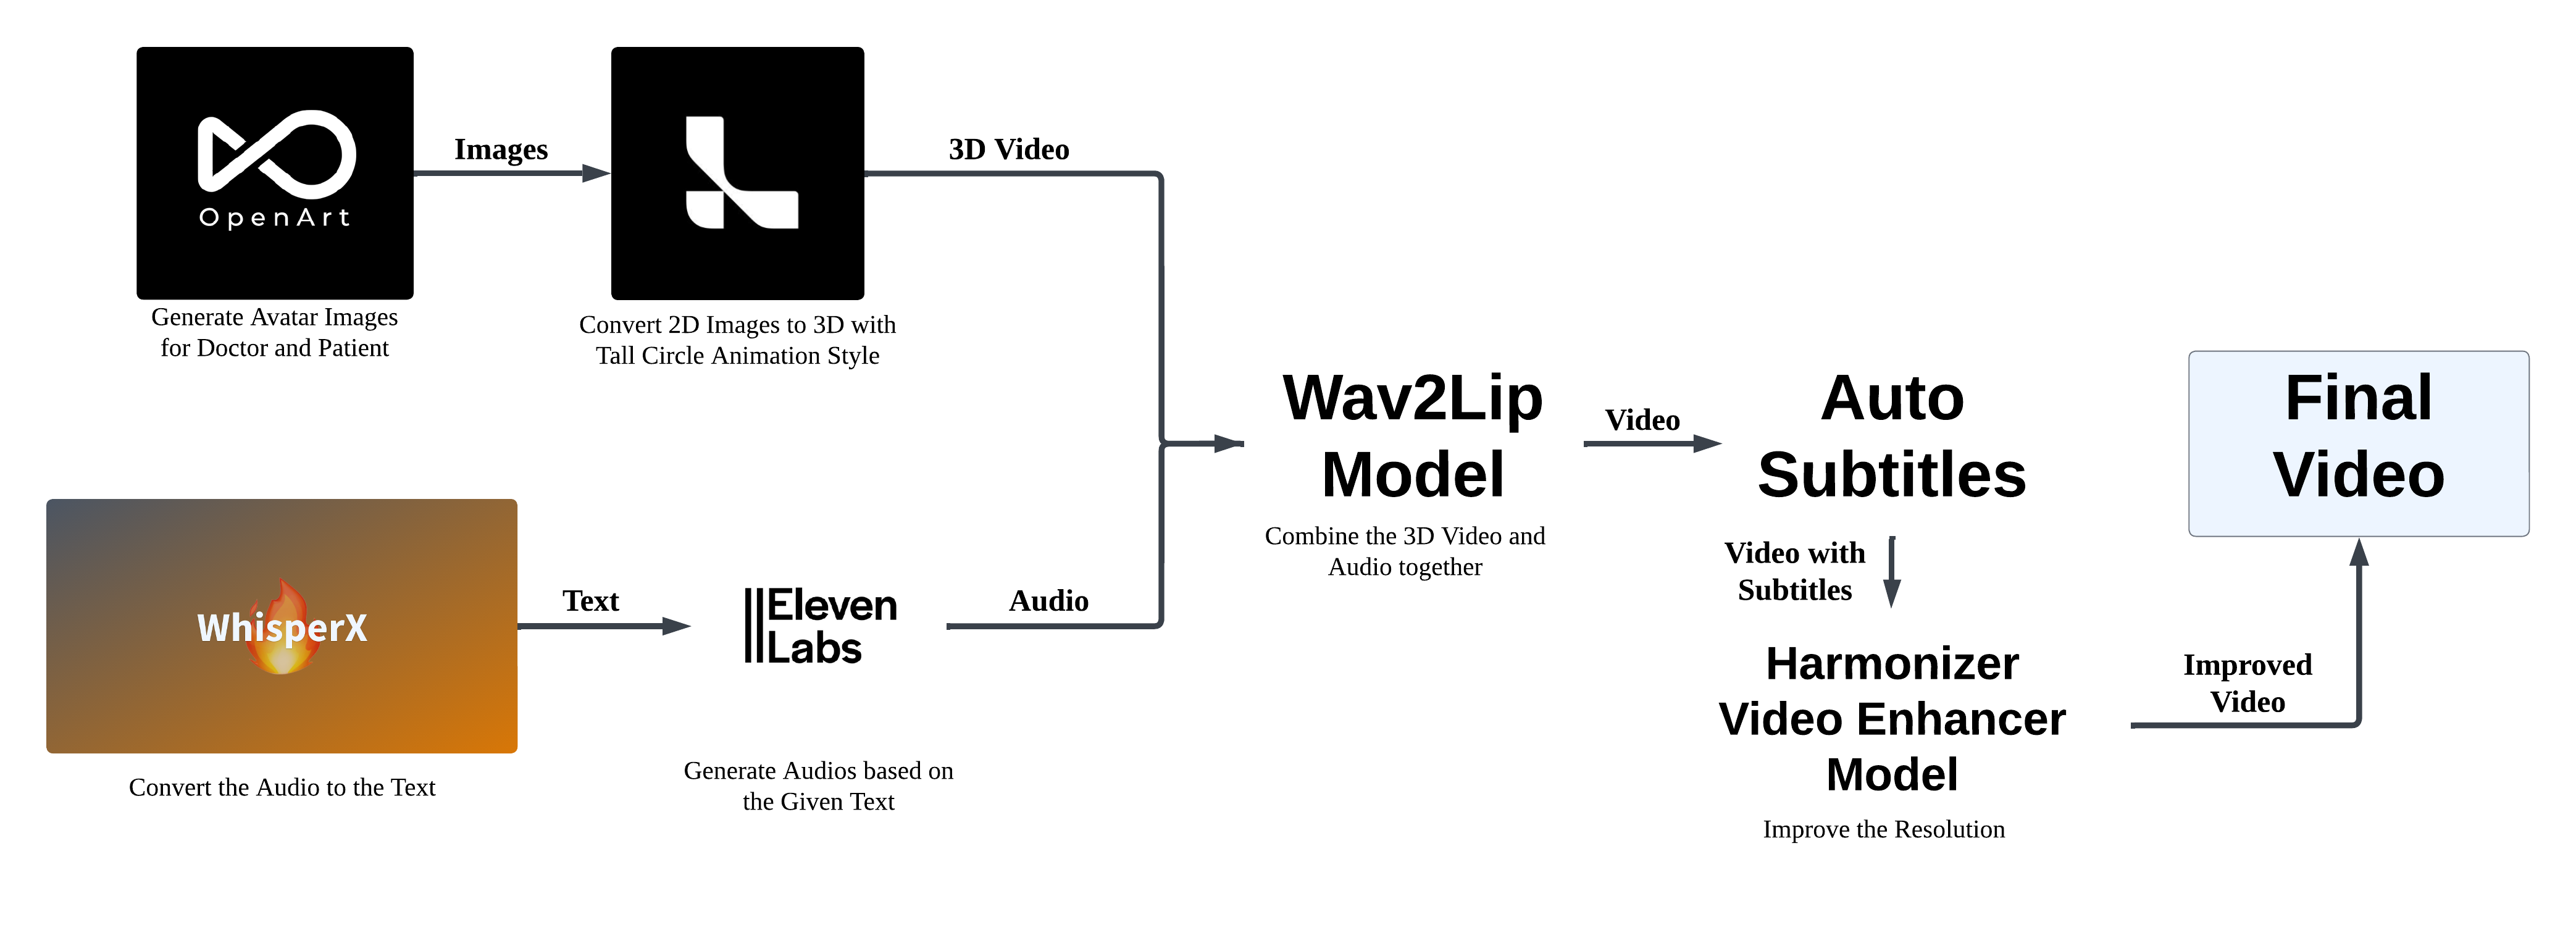

## Text to Audio

In [ ]:
ELEVENLABS_KEY = "1435ec5fa492496fdd1015c8d916b969"
set_api_key(ELEVENLABS_KEY)

In [ ]:
def split_into_sentences(text):
    sentences = re.split(r'/', text)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

In [ ]:
PATIENT_TEXT = "Come in.  Yes.  I have constant cough and I feel out of breath.  It's mainly dry cough, but some mornings there's mucus. It's mainly when I exert myself. High blood pressure, but it's already controlled through the diet. No. Shellfish. Ummm, my mom had migraines in her 20s, My dad has high blood pressure. Well, I attended a large wedding two weeks ago. Yes, half a pack of cigarettes daily. No, I don't drink. Yes. Sounds good, Thanks."
DOCTOR_TEXT = "Miss X?  Okay, why are you here today? Dry cough or with mucus? And the shortness of breath? Any previous health conditions? Medications? Allergies? Family health history? Do you have any recent exposures or travel? Do you smoke? Any alcohol use? Are you married? Okay, So based on what you said, I'd like to proceed with some testing, After that, please rest and stay hydrated."

In [ ]:
# patient_sentences = split_into_sentences(patient_dialogue)
# doctor_sentences = split_into_sentences(doctor_dialogue)
patient_sentences = split_into_sentences(PATIENT_TEXT)
doctor_sentences = split_into_sentences(DOCTOR_TEXT)
PATIENT_VOICE = "Emily"
DOCTOR_VOICE = "Grace"

## Video Generation

In [ ]:
def showVideo(USER_PATH):
    """Function to display video in Colab"""
    if not os.path.isfile(USER_PATH):
        print("ERROR: File not found!")
        raise SystemExit(0)

    mp4 = open(USER_PATH, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""
    <video controls width=600>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))

def get_video_resolution():
    """Function to get the resolution of a video"""
    video = cv2.VideoCapture(USER_PATH)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def resize_video(new_resolution):
    """Function to resize a video"""
    video = cv2.VideoCapture(USER_PATH)
    fourcc = int(video.get(cv2.CAP_PROP_FOURCC))
    fps = video.get(cv2.CAP_PROP_FPS)
    width, height = new_resolution
    output_path = os.path.splitext(USER_PATH)[0] + '_720p.mp4'
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        success, frame = video.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, new_resolution)
        writer.write(resized_frame)

    video.release()
    writer.release()

In [ ]:
def generate_audio_and_video(sentences, voice, video_path, output_folder):
    for i, sentence in enumerate(sentences):
        %cd /content/Wav2Lip
        USER_AUDIOPATH = f'{output_folder}/audio_{i}.wav'
        output_file_path = './results/result_voice.mp4'
        # output_file_path = f'{output_folder}/video_{i}.mp4'
        # ensure_directory_exists(output_file_path)

        # audio = generate(
        #     text=sentence,
        #     voice=voice,
        #     model="eleven_multilingual_v2"
        # )
        # save(audio, USER_AUDIOPATH)

        USER_PATH = video_path

        %cd /content/Wav2Lip
        if os.path.exists(output_file_path):
            os.remove(output_file_path)

        pad_top = 0
        pad_bottom = 10
        pad_left = 0
        pad_right = 0
        rescaleFactor = 1
        nosmooth = True

        use_hd_model = False
        checkpoint_path = 'checkpoints/wav2lip.pth' if not use_hd_model else 'checkpoints/wav2lip_gan.pth'

        if nosmooth == False:
            !python inference.py --checkpoint_path $checkpoint_path --face "$USER_PATH" --audio "$USER_AUDIOPATH" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
        else:
            !python inference.py --checkpoint_path $checkpoint_path --face "$USER_PATH" --audio "$USER_AUDIOPATH" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

        if os.path.exists(output_file_path):
            clear_output()
            print("Final Video Preview")
            print("Download this video from", output_file_path)
            showVideo(output_file_path)
        else:
            print("Processing failed. Output video not found.")

        new_file_path = f'{output_folder}/video_{i}.mp4'
        shutil.copy(output_file_path, new_file_path)

In [ ]:
patient_video_path = '/content/drive/MyDrive/DH_Project/patient_leiapix.mp4'
doctor_video_path = '/content/drive/MyDrive/DH_Project/doctor_leiapix.mp4'

In [ ]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
ensure_directory_exists('/content/drive/MyDrive/DH_Project/patient')
ensure_directory_exists('/content/drive/MyDrive/DH_Project/doctor')

In [ ]:
generate_audio_and_video(patient_sentences, PATIENT_VOICE, patient_video_path, '/content/drive/MyDrive/DH_Project/patient')
generate_audio_and_video(doctor_sentences, DOCTOR_VOICE, doctor_video_path, '/content/drive/MyDrive/DH_Project/doctor')

Final Video Preview
Download this video from ./results/result_voice.mp4


In [ ]:
def extract_number(filename):
    numbers = ''.join(filter(str.isdigit, filename))
    return int(numbers) if numbers else None

def cross_concatenate_clips(patient_folder, doctor_folder, output_path):
    clips = []
    patient_files = sorted([f for f in os.listdir(patient_folder) if f.endswith('.mp4')], key=extract_number)
    doctor_files = sorted([f for f in os.listdir(doctor_folder) if f.endswith('.mp4')], key=extract_number)

    max_length = max(len(patient_files), len(doctor_files))

    for i in range(max_length):
        if i < len(patient_files):
            patient_video_path = os.path.join(patient_folder, patient_files[i])
            print(f"Adding patient video: {patient_video_path}")
            clips.append(VideoFileClip(patient_video_path))

        if i < len(doctor_files):
            doctor_video_path = os.path.join(doctor_folder, doctor_files[i])
            print(f"Adding doctor video: {doctor_video_path}")
            clips.append(VideoFileClip(doctor_video_path))

    if clips:
        final_clip = concatenate_videoclips(clips, method="compose")
        final_clip.write_videofile(output_path, codec="libx264", fps=24)
    else:
        print("No video clips found to concatenate.")

In [ ]:
cross_concatenate_clips('/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/final_video.mp4')

In [ ]:
# if first_speaker == 'Patient':
#   cross_concatenate_clips('/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/final_video.mp4')
# else:
#   cross_concatenate_clips('/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/final_video.mp4')

## Subtitle Generation

In [ ]:
!auto_subtitle '/content/drive/MyDrive/DH_Project/final_video.mp4' -o '/content/drive/MyDrive/DH_Project/subtitled/'

## Resolution Improvement

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')

In [ ]:
!git clone https://github.com/ZHKKKe/Harmonizer.git
%cd Harmonizer

In [ ]:
!conda create -n harmonizer python=3.8 -y
!echo "source activate harmonizer" > ~/.bashrc
!source ~/.bashrc

In [ ]:
!pip install -r src/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 113.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/

In [ ]:
!mkdir -p ./demo/video_enhancement/example
!cp /content/drive/MyDrive/DH_Project/subtitled/final_video.mp4 ./demo/video_enhancement/example/

In [ ]:
%env PYTHONPATH=

In [ ]:
!pip install opencv-python-headless

In [ ]:
!pip install torchvision

In [ ]:
!python -m demo.video_enhancement.run --example-path ./demo/video_enhancement/example



Video Enhancement Demo
--------------------------------------------------------------------------------
  - Example Path: ./demo/video_enhancement/example
  - Pretrained Model: ./pretrained/enhancer.pth


The enhanced videos will be saved in: ./demo/video_enhancement/example/enhanced

Create/load Enhancer...

Process video: 0.mp4...
100% 62/62 [00:15<00:00,  3.95frame/s]


Finished.




In [ ]:
!cp ./demo/video_enhancement/example/final_video.mp4 /content/drive/MyDrive/DH_Project/final_video_enhanced_cap.mp4

# Test

In [5]:
doctor_dialogue = None
patient_dialogue = None
first_speaker = None

In [6]:
def split_into_sentences(text):
    sentences = re.split(r'/', text)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

In [7]:
def showVideo(USER_PATH):
    """Function to display video in Colab"""
    if not os.path.isfile(USER_PATH):
        print("ERROR: File not found!")
        raise SystemExit(0)

    mp4 = open(USER_PATH, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f"""
    <video controls width=600>
        <source src="{data_url}" type="video/mp4">
    </video>
    """))

def get_video_resolution():
    """Function to get the resolution of a video"""
    video = cv2.VideoCapture(USER_PATH)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def resize_video(new_resolution):
    """Function to resize a video"""
    video = cv2.VideoCapture(USER_PATH)
    fourcc = int(video.get(cv2.CAP_PROP_FOURCC))
    fps = video.get(cv2.CAP_PROP_FPS)
    width, height = new_resolution
    output_path = os.path.splitext(USER_PATH)[0] + '_720p.mp4'
    writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        success, frame = video.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, new_resolution)
        writer.write(resized_frame)

    video.release()
    writer.release()

In [8]:
def generate_audio_and_video(sentences, voice, video_path, output_folder):
    for i, sentence in enumerate(sentences):
        %cd /content/Wav2Lip
        USER_AUDIOPATH = f'{output_folder}/audio_{i}.wav'
        output_file_path = './results/result_voice.mp4'
        # output_file_path = f'{output_folder}/video_{i}.mp4'
        # ensure_directory_exists(output_file_path)

        # audio = generate(
        #     text=sentence,
        #     voice=voice,
        #     model="eleven_multilingual_v2"
        # )
        # save(audio, USER_AUDIOPATH)

        USER_PATH = video_path

        %cd /content/Wav2Lip
        if os.path.exists(output_file_path):
            os.remove(output_file_path)

        pad_top = 0
        pad_bottom = 10
        pad_left = 0
        pad_right = 0
        rescaleFactor = 1
        nosmooth = True

        use_hd_model = False
        checkpoint_path = 'checkpoints/wav2lip.pth' if not use_hd_model else 'checkpoints/wav2lip_gan.pth'

        if nosmooth == False:
            !python inference.py --checkpoint_path $checkpoint_path --face "$USER_PATH" --audio "$USER_AUDIOPATH" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor
        else:
            !python inference.py --checkpoint_path $checkpoint_path --face "$USER_PATH" --audio "$USER_AUDIOPATH" --pads $pad_top $pad_bottom $pad_left $pad_right --resize_factor $rescaleFactor --nosmooth

        if os.path.exists(output_file_path):
            clear_output()
            print("Final Video Preview")
            print("Download this video from", output_file_path)
            showVideo(output_file_path)
        else:
            print("Processing failed. Output video not found.")

        new_file_path = f'{output_folder}/video_{i}.mp4'
        shutil.copy(output_file_path, new_file_path)

In [9]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
def extract_number(filename):
    numbers = ''.join(filter(str.isdigit, filename))
    return int(numbers) if numbers else None

def cross_concatenate_clips(patient_folder, doctor_folder, output_path):
    clips = []
    patient_files = sorted([f for f in os.listdir(patient_folder) if f.endswith('.mp4')], key=extract_number)
    doctor_files = sorted([f for f in os.listdir(doctor_folder) if f.endswith('.mp4')], key=extract_number)

    max_length = max(len(patient_files), len(doctor_files))

    for i in range(max_length):
        if i < len(patient_files):
            patient_video_path = os.path.join(patient_folder, patient_files[i])
            print(f"Adding patient video: {patient_video_path}")
            clips.append(VideoFileClip(patient_video_path))

        if i < len(doctor_files):
            doctor_video_path = os.path.join(doctor_folder, doctor_files[i])
            print(f"Adding doctor video: {doctor_video_path}")
            clips.append(VideoFileClip(doctor_video_path))

    if clips:
        final_clip = concatenate_videoclips(clips, method="compose")
        final_clip.write_videofile(output_path, codec="libx264", fps=24)
    else:
        print("No video clips found to concatenate.")

In [11]:
def subtitleGenerator():
  !auto_subtitle '/content/drive/MyDrive/DH_Project/final_video.mp4' -o '/content/drive/MyDrive/DH_Project/subtitled/'

In [12]:
def vidEnhancer():
    # os.chdir("/content")
    !wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    !chmod +x Miniconda3-latest-Linux-x86_64.sh
    !bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

    import sys
    sys.path.append('/usr/local/lib/python3.8/site-packages/')

    !git clone https://github.com/ZHKKKe/Harmonizer.git
    %cd Harmonizer

    !conda create -n harmonizer python=3.8 -y
    !echo "source activate harmonizer" > ~/.bashrc
    !source ~/.bashrc

    !pip install -r src/requirements.txt
    !mkdir -p ./demo/video_enhancement/example
    !cp /content/drive/MyDrive/DH_Project/subtitled/final_video.mp4 ./demo/video_enhancement/example/
    %env PYTHONPATH=
    !pip install opencv-python-headless
    !pip install torchvision
    !python -m demo.video_enhancement.run --example-path ./demo/video_enhancement/example

    !cp ./demo/video_enhancement/example/final_video.mp4 /content/drive/MyDrive/DH_Project/final_video_enhanced_cap.mp4

# Send Video Back

In [14]:
# Step 1: Install pyngrok
!pip install flask pyngrok

# Step 2: Set the ngrok auth token
from pyngrok import ngrok
from flask import Flask, send_file, request
ngrok.set_auth_token("2YmzMrLkgNGx5ku1w1rByTdUK61_2XZbn5stZH3kQ9P4Wsjkk")  # Replace <your_auth_token> with your actual ngrok auth token.

# Step 3: Write your Flask app and start ngrok tunnel
from flask import Flask
app = Flask(__name__)

@app.route('/', methods=['POST'])
def process_transcript():

    data = request.get_json()
    doctor_dialogue = data.get('doctor_dialogue')
    patient_dialogue = data.get('patient_dialogue')
    first_speaker = data.get('first_speaker')

    # print(doctor_dialogue)
    # print(patient_dialogue)
    # print(first_speaker)

    # Process the transcript file to generate a video
    ELEVENLABS_KEY = "1435ec5fa492496fdd1015c8d916b969"
    set_api_key(ELEVENLABS_KEY)

    patient_sentences = split_into_sentences(patient_dialogue)
    doctor_sentences = split_into_sentences(doctor_dialogue)

    # print(patient_sentences)
    PATIENT_VOICE = "Emily"
    DOCTOR_VOICE = "Grace"

    patient_video_path = '/content/drive/MyDrive/DH_Project/patient_leiapix.mp4'
    doctor_video_path = '/content/drive/MyDrive/DH_Project/doctor_leiapix.mp4'

    ensure_directory_exists('/content/drive/MyDrive/DH_Project/patient')
    ensure_directory_exists('/content/drive/MyDrive/DH_Project/doctor')

    generate_audio_and_video(patient_sentences, PATIENT_VOICE, patient_video_path, '/content/drive/MyDrive/DH_Project/patient')
    generate_audio_and_video(doctor_sentences, DOCTOR_VOICE, doctor_video_path, '/content/drive/MyDrive/DH_Project/doctor')

    if first_speaker == 'Patient':
      cross_concatenate_clips('/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/final_video.mp4')
    else:
      cross_concatenate_clips('/content/drive/MyDrive/DH_Project/doctor', '/content/drive/MyDrive/DH_Project/patient', '/content/drive/MyDrive/DH_Project/final_video.mp4')

    subtitleGenerator()

    vidEnhancer()

    # For demonstration, we'll just return a pre-existing video file
    video_file_path = '/content/drive/MyDrive/DH_Project/final_video_enhanced_cap.mp4'

    # Check if the video file exists
    if not os.path.exists(video_file_path):
        return "Video file not found", 404

    return send_file(video_file_path, as_attachment=True, download_name='Video.mp4')

# Start ngrok when app is run
if __name__ == '__main__':
    # The ngrok tunnel will be created when you run this cell
    public_url = ngrok.connect(5000)
    print(f'ngrok tunnel "{public_url}" -> "http://127.0.0.1:5000"')
    app.run()



Final Video Preview
Download this video from ./results/result_voice.mp4


Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_0.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_0.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_1.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_1.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_2.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_2.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_3.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_3.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_4.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_4.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_5.mp4
Adding doctor video: /content/drive/MyDrive/DH_Project/patient/video_5.mp4
Adding patient video: /content/drive/MyDrive/DH_Project/doctor/video_6.mp4
Adding doctor video: /con

MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/DH_Project/final_video.mp4



t:   0%|          | 3/1319 [00:00<03:03,  7.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DH_Project/doctor/video_0.mp4, 691200 bytes wanted but 0 bytes read,at frame 21/26, at time 0.70/0.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+

t:   2%|▏         | 22/1319 [00:00<00:24, 52.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/DH_Project/patient/video_0.mp4, 691200 bytes wanted but 0 bytes read,at frame 22/26, at time 0.73/0.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/DH_Project/final_video.mp4
100%|████████████████████████████████████████| 461M/461M [00:03<00:00, 157MiB/s]
Extracting audio from final_video...
Generating subtitles for final_video... This might take a while.
Detected language: English
100% 5496/5496 [00:05<00:00, 929.15frames/s]
Adding subtitles to final_video...
Saved subtitled video to /content/drive/MyDrive/DH_Project/subtitled/final_video.mp4.
--2023-11-28 07:11:12--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120986213 (115M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 115.38M   162MB/s    in 0.7s    

2023-11-28 07:11:13 (162 MB/s) 

env: PYTHONPATH=
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.0 MB/s eta 0:00:00
/content/Wav2Lip
/content/Wav2Lip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.3 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/Wav2Lip/inference.py", line 12, in <module>
    import audio
  File "/content/Wav2Lip/audio.py", line 1, in <module>
    import librosa
ModuleNotFoundError: No module named 'librosa'
/usr/local/bin/python: Error while finding module specification for 'demo.video_enhancement.run' (ModuleNotFoundError: No module named 'demo')
cp: cannot stat './demo/video_enhancement/example/final_video.mp4': No such file or directory


INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 07:21:48] "POST / HTTP/1.1" 200 -
ERROR:__main__:Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-14-252cfb0962d7>", line 42, in process_transcript
    generate_audio_and_video(patient_sentences, PATIENT_VOICE, patient_video_path, '/content/drive/MyDrive/DH_Project/patient')
  File "<ipython-input-8-673f3574936c>", line 46, in generate_audio_and_video
   

Processing failed. Output video not found.
